# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [433]:
import pandas as pd
df = pd.read_csv('/datasets/data.csv')
df.info()
df.head()
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


54

In [434]:
df.sort_values(by = 'days_employed', ascending = False).head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
6954,0,401755.400475,56,среднее,1,вдовец / вдова,2,F,пенсионер,0,176278.441171,ремонт жилью
10006,0,401715.811749,69,высшее,0,Не женат / не замужем,4,F,пенсионер,0,57390.256908,получение образования
7664,1,401675.093434,61,среднее,1,женат / замужем,0,F,пенсионер,0,126214.519212,операции с жильем
2156,0,401674.466633,60,среднее,1,женат / замужем,0,M,пенсионер,0,325395.724541,автомобили
7794,0,401663.850046,61,среднее,1,гражданский брак,1,F,пенсионер,0,48286.441362,свадьба


In [435]:
df.sort_values(by = 'dob_years', ascending = True).head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
6859,1,-260.992722,0,неоконченное высшее,2,гражданский брак,1,F,сотрудник,0,128246.646591,покупка недвижимости
16042,2,-176.404487,0,среднее,1,женат / замужем,0,F,сотрудник,0,137563.630693,жилье
7034,0,366067.781030,0,высшее,0,Не женат / не замужем,4,F,пенсионер,0,263121.074528,образование
21179,2,-108.967042,0,высшее,0,женат / замужем,0,M,компаньон,0,240702.007382,строительство жилой недвижимости
4147,0,-3549.117333,0,среднее,1,в разводе,3,M,сотрудник,0,108130.933212,покупка жилой недвижимости


**Вывод**

Обраружены пропуски в столбцах со стажем и доходом.
В стобцах с катагориальными значениями без аналогов с идентификационными номерами может понадобиться я убрать неявные дубликаты.

Попадаются отрицательные стажи, попадаются стажи более тысячи лет. Число дней в стаже дробное. Скорее всего, стаж был подсчитан как разность дат (это объясняет отрицательные значения) в секундах и переведён в дни.

Попадаются люди с нулевым возрастом.

## Шаг 2. Предобработка данных

### Обработка пропусков

In [436]:
df.isnull().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Гипотеза: пропуски в столбцах days_employed и total_income находятся в одних и тех же строках.

In [437]:
df[df['days_employed'].isnull()].equals(df[df['total_income'].isnull()])

True

**Вывод**

Гипотеза подтведилась. Поскольку отсутсвуют сразу оба значения у тех же людей, скорее всего они работали неофициально на серую зарплату, либо не работали вообще.

Поскольку стаж не известен, точнее всего будет взять медианный доход, сгруппировав категории по образованию и возрасту.
В настоящем проекте я бы не стал такого делать, но задание требует объяснение для заполнения пропусков, то есть их надо заполнить.

Сгруппируем людей по образованию, возрасту и посмотрим на их медианный доход. Учитываем даже строки с нулевым возрастом.
Для корректного заполнения пустых ячеек явные будубликаты требуется убрать уже сейчас.


In [438]:
df.drop_duplicates(inplace = True)
df_income = df.groupby(['education_id','dob_years'])['total_income'].median()

Поскольку в серии нет всех возможных возрастов, словарём не обойтись, и для заполнения недостающих значений придётся написать функцию.

In [439]:
ed_age_to_income_dict = df_income.to_dict()
#для функции необходимо знать минимальные возраста для каждой категории
min_ages_dict = df.groupby('education_id')['dob_years'].min().to_dict()

def ed_age_to_income_func(row):
    age = row.dob_years
    ed = row.education_id
    
    #для людей младше минимума в выборке ставим минимальный возраст в выборке
    if age < min_ages_dict[ed] and age > 0:
        age = min_ages_dict[ed] 
    
    #если значения возраста нет в выборке, берём его из предыдушего
    dict_keys = ed_age_to_income_dict.keys()
    while (ed, age) not in dict_keys:
        age -= 1
   
    return ed_age_to_income_dict[ed, age]

In [440]:
df['total_income'] = df.apply(lambda x: ed_age_to_income_func(x) if pd.isnull(x.total_income) else x.total_income, axis=1)

Заполним пропуски в колонке со стажем медианными значениями по возрастам. Используем тот же принцип, что и с доходом, но без учёта образования.
Однако, многие значения стажа отрицательны, очевидно, при их нахождении разностью уменьшаемое и вычитаемое менялось местами. Придётся привести их к модулю уже на этом этапе.

In [441]:
df['days_employed'] = df['days_employed'].abs()

df_days_employed = df.groupby('dob_years')['days_employed'].median()

age_to_days_employed_dict = df_days_employed.to_dict()
#для функции необходимо знать минимальный возраст в выборке
min_age = df['dob_years'][df['dob_years'] != 0].min()

def ed_age_to_days_employed_func(row):
    age = row.dob_years
 
    #для людей младше минимума в выборке ставим минимальный возраст в выборке
    if age < min_age and age > 0:
        age = min_age 
    
    dict_keys = age_to_days_employed_dict.keys()
    while age not in dict_keys:
        age -= 1
    
    return age_to_days_employed_dict[age]


In [442]:
df['days_employed'] = df.apply(lambda x: ed_age_to_days_employed_func(x) if pd.isnull(x.days_employed) else x.days_employed, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21471 entries, 0 to 21524
Data columns (total 12 columns):
children            21471 non-null int64
days_employed       21471 non-null float64
dob_years           21471 non-null int64
education           21471 non-null object
education_id        21471 non-null int64
family_status       21471 non-null object
family_status_id    21471 non-null int64
gender              21471 non-null object
income_type         21471 non-null object
debt                21471 non-null int64
total_income        21471 non-null float64
purpose             21471 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.1+ MB


Все пропуски заменены на медианные значения категорий.

### Замена типа данных

В таблице нет данных формата object, поэтому заменим тип float на integer в стобцах с доходом и стажем. Точность после запятой для них не нужна, а там данных int занимает меньше места и будет быстрее обрабатываться.

In [443]:
df['days_employed'] = df['days_employed'].astype(int)
df['total_income'] = df['total_income'].astype(int)

**Вывод**

Поскольку преобразовывали числа в числа, был пременён метод astype().
Теперь таблица будет легче, а операции над ней будут производиться быстрее.

### Обработка дубликатов

Явные дубликаты были убраны во время заполнения пустых ячеек.
Посмотрим список значений у каждой колонки с категориальными данными:

In [444]:
category_list = ['education','family_status','gender','income_type','purpose']
for category in category_list:
    print(df[category].value_counts())
    print()

среднее                13705
высшее                  4710
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   273
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

женат / замужем          12344
гражданский брак          4163
Не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64

F      14189
M       7281
XNA        1
Name: gender, dtype: int64

сотрудник          11091
компаньон           5080
пенсионер           3837
госслужащий         1457
безработный            2
предприниматель        2
в декрете              1
студент                1
Name: income_type, dtype: int64

свадьба                                   79

**Вывод**

В стобец с образованием данные заносились с разным региством, а столбец целей — просто со слов клиента
Неявные дубликаты в столбце образования можно убрать обычной функцией lower(), а для целей уже требуется лемматизация.


In [445]:
df['education'] = df['education'].apply(lambda x: x.lower()) 
df['education'].value_counts()

среднее                15188
высшее                  5251
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

### Лемматизация

In [446]:
from pymystem3 import Mystem 
m = Mystem() 

df['purpose'] = df['purpose'].apply(lambda x: m.lemmatize(x))
df['purpose'].value_counts()

[автомобиль, \n]                                          972
[свадьба, \n]                                             793
[на,  , проведение,  , свадьба, \n]                       773
[сыграть,  , свадьба, \n]                                 769
[операция,  , с,  , недвижимость, \n]                     675
[покупка,  , коммерческий,  , недвижимость, \n]           662
[операция,  , с,  , жилье, \n]                            652
[покупка,  , жилье,  , для,  , сдача, \n]                 652
[операция,  , с,  , коммерческий,  , недвижимость, \n]    650
[покупка,  , жилье, \n]                                   646
[жилье, \n]                                               646
[покупка,  , жилье,  , для,  , семья, \n]                 638
[строительство,  , собственный,  , недвижимость, \n]      635
[недвижимость, \n]                                        633
[операция,  , со,  , свой,  , недвижимость, \n]           627
[строительство,  , жилой,  , недвижимость, \n]            625
[покупка

**Вывод**

Лемматизация произведена с помощью библиотеки pymystem3, потому что на русском языке начальную форму слова куда проще воспринимать, чем корень.

### Категоризация данных

Разделим получившиеся данные на категории:

1. Жилье.
Сюда можно отнести как покупку жилья, так и затраты на его строительства, потому что по сути это то же самое.

2. Автомобиль.
Определённо речь всегда идёт о покупке.

3. Свадьба.
Без комментариев.

4. Нежилая недвижимость.
По закону идёт строгое разделение недвижимости на жилую и нежилую. Если указывается просто "недвижимость", значит она не относится к жилью.

5. Коммерческая недвижимость.
При выдаче кредита всегда указыается цель, и если целью является коммерческое использование, это должно быть указано.
Сюда же отнесеры операции с ней. Вряд ли кредит берут на что-то, кроме покупки.

6. Образование.
Расходы на образование.

7. Ремонт жилья.
Без комментариев.

Для категоризации требуется написать функцию.

In [447]:
def categorize_goals(goal):
    
    #жилая недвижимость
    if 'жилье' in goal or 'жилой' in goal:
        if 'ремонт' in goal:
            return 'ремонт жилья'
        return 'покупка жилья'
    
    #автомобиль
    if 'автомобиль' in goal:
        return 'автомобиль'
        
    #иная недвижимость
    if 'недвижимость' in goal:
        if 'коммерческий' in goal:
            return 'коммерческая недвижимость'
        return 'нежилая недвижимость'
    
    #свадьба
    if 'свадьба' in goal:
        return 'свадьба'
    
    #образование
    if 'образование' in goal:
        return 'образование'
    
    else:
        return goal
    
    
df['purpose'] = df['purpose'].apply(categorize_goals)
df['purpose'].value_counts()

покупка жилья                5085
автомобиль                   4308
образование                  4014
нежилая недвижимость         3810
свадьба                      2335
коммерческая недвижимость    1312
ремонт жилья                  607
Name: purpose, dtype: int64

Категоризируем людей по уровню дохода.
Для выделения категорий нужно знать максимум и минимум.

In [448]:
print(df['total_income'].max(),df['total_income'].min())

2265604 20667


Выделим категории по доходу в тысячах рублях:
1. до 30
2. 30-60
3. 60-120
4. 120-250
5. 250-500
6. 500-1000
7. более 1000

In [449]:
def categorize_income(income):
    
    if income < 30000:
        return '1. до 30К'
    
    if income <= 60000:
        return '2. 30-60К'

    if income <= 120000:
        return '3. 60-120К'
    
    if income <= 250000:
        return '4. 120-250К'
    
    if income <= 500000:
        return '5. 250-500К'
    
    if income <= 1000000:
        return '6. 500-1000К'
    
    else:
        return '7. более 1000К'
    
df['income_categorized'] = df['total_income'].apply(categorize_income)
df['income_categorized'].value_counts()

4. 120-250К       11640
3. 60-120К         6211
5. 250-500К        2592
2. 30-60К           784
6. 500-1000К        197
7. более 1000К       25
1. до 30К            22
Name: income_categorized, dtype: int64

**Вывод**

Данные успешно категоризированные и готовы к анализу.

В данных присутствуют артефакты, такие как тысячилетние стажи у пенсионеров и нулевой возраст у некоторых людей. Первые появились, скорее всего из-за неправильной обработки данных пенсионеров, а вторые в результате отсутствия возраста у какой-то категории.

Функция подсчёта медианной заработной платы можно считать применимой к группе с нулевым возрастом, так как, скорее всего, они из одного источника и имеют между собой что-то общее.
Отрицательный стаж был исправлен перед прим
Исправлять остальные артефакты не имеет смылса, так как при исследовании они не будут использоваться.

Отрицательное количество детей, скорее всего, было получено из-за ошибочного учёта дефиса как минуса.

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

Избавляемся от отрицательных значений в количестве детей и смотрим зависимости среднего значения просрочки по их количеству.

доля людей с долгом
 children
0     0.075353
1     0.091639
2     0.094542
3     0.081818
4     0.097561
5     0.000000
20    0.105263
Name: debt, dtype: float64

количество людей в выборке
 children
0     14107
1      4856
2      2052
3       330
4        41
5         9
20       76
Name: debt, dtype: int64


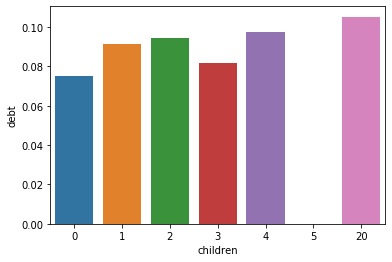

In [450]:
import seaborn as sns
df['children'] = df['children'].abs()
child_debt = df.sort_values('children').groupby('children')['debt'].mean()

print('доля людей с долгом\n',child_debt)
print('\nколичество людей в выборке\n',df.sort_values('children').groupby('children')['debt'].count())

sns.barplot(data = child_debt.reset_index(), x='children', y='debt')

**Вывод**

Прослеживается явная положительная зависимость между количеством детей и наличием просроченнх долгов в категории от 0 до 2 детей.
Выборки с большим количеством детей сложно назвать репрезентативными из-за малого размера.
Значения с 20 детьми, скорее всего, являются неконнектными.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

Рассмотрим долю должников по категориям семейного положения.

           family_status      debt
0  Не женат / не замужем  0.097509
1              в разводе  0.071130
2         вдовец / вдова  0.065693
3       гражданский брак  0.093202
4        женат / замужем  0.075421


[Text(0, 0, 'Не женат / не замужем'),
 Text(0, 0, 'в разводе'),
 Text(0, 0, 'вдовец / вдова'),
 Text(0, 0, 'гражданский брак'),
 Text(0, 0, 'женат / замужем')]

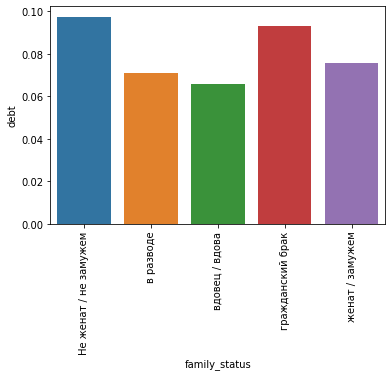

In [457]:
married_debt = df.sort_values('family_status').groupby('family_status')['debt'].mean().reset_index()
print(married_debt)

plot = sns.barplot(data = married_debt, x='family_status', y='debt')

plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

**Вывод**

Группы наибольшего риска - холостые/незамужние и люди, живущие в гражданском браке.
Наименьший риск у разведённых и вдов/вдовцов.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Рассмотрим долю людей с просроченными кредитами в каждой категории.

  income_categorized      debt
0          1. до 30К  0.090909
1          2. 30-60К  0.059949
2         3. 60-120К  0.083400
3        4. 120-250К  0.084192
4        5. 250-500К  0.069444
5       6. 500-1000К  0.060914
6     7. более 1000К  0.080000


[Text(0, 0, '1. до 30К'),
 Text(0, 0, '2. 30-60К'),
 Text(0, 0, '3. 60-120К'),
 Text(0, 0, '4. 120-250К'),
 Text(0, 0, '5. 250-500К'),
 Text(0, 0, '6. 500-1000К'),
 Text(0, 0, '7. более 1000К')]

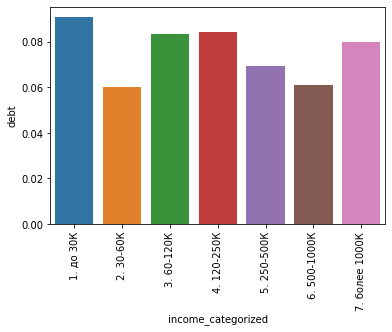

In [460]:
income_debt = df.groupby('income_categorized')['debt'].mean().reset_index()
print(income_debt)

plot2 = sns.barplot(data = income_debt, x='income_categorized', y='debt')

plot2.set_xticklabels(plot2.get_xticklabels(), rotation=90)

**Вывод**

Зависимости не обранужено.

- Как разные цели кредита влияют на его возврат в срок?

Посмотрим долю просроченных кредитов по категориям целей:

                     purpose      debt
0                 автомобиль  0.093547
1  коммерческая недвижимость  0.075457
2       нежилая недвижимость  0.075066
3                образование  0.092177
4              покупка жилья  0.071190
5               ремонт жилья  0.057661
6                    свадьба  0.079657


[Text(0, 0, '1. до 30К'),
 Text(0, 0, '2. 30-60К'),
 Text(0, 0, '3. 60-120К'),
 Text(0, 0, '4. 120-250К'),
 Text(0, 0, '5. 250-500К'),
 Text(0, 0, '6. 500-1000К'),
 Text(0, 0, '7. более 1000К')]

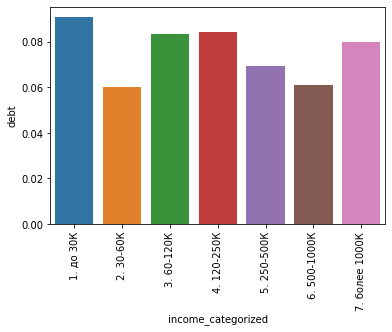

In [461]:
goal_debt = df.groupby('purpose')['debt'].mean().reset_index()
print(goal_debt)
plot3 = sns.barplot(data = income_debt, x='income_categorized', y='debt')

plot3.set_xticklabels(plot3.get_xticklabels(), rotation=90)

**Вывод**

Зависимость отсутсвует.

## Шаг 4. Общий вывод

Зависимости от уровня дохода не обнаружно.
Очень вероятно, что количество детей прямо пропорционально доле должников. Доля людей с количеством детей более двух — минимальна. Возможно, это связано с расходами.
Судя по распределению должников по категориям семейного положения, должна обнаружиться сильная отрицательная корреляция между количеством должников и их возрастом. Для этого требуеются дополнительные исследования.